In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from classificatiom_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from classificatiom_model import evaluate_classification_model as evaluate_model

from torchvision.models import resnet50

from torchviz import make_dot


In [2]:
# 初始化ResNet50模型
# 使用预训练的ImageNet权重加载ResNet50模型
model = resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

# 打印模型结构
print("ResNet50模型结构:")
print(model)  # 输出完整的模型层次结构

# 计算模型参数数量
# numel()函数返回张量中的元素数量，这里用于计算每个参数的数量并求和
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数数量: {total_params}")  # 显示模型的总参数量

# 绘制模型结构图
try:
    # 尝试使用torchviz可视化模型结构
    
    # 创建一个随机输入 - 符合ResNet50输入要求的尺寸(批次大小, 通道数, 高度, 宽度)
    x = torch.randn(1, 3, 224, 224)  # 3通道RGB图像，尺寸为224x224
    y = model(x)  # 前向传播，获取模型输出
    
    # 生成模型结构图 - 使用make_dot函数创建计算图
    dot = make_dot(y, params=dict(model.named_parameters()))  # 将模型参数添加到图中
    dot.format = 'png'  # 设置输出格式为PNG
    dot.render("resnet50_model_structure", cleanup=True)  # 渲染并保存图像，cleanup=True表示删除中间文件
    print("模型结构图已保存为 'resnet50_model_structure.png'")
except ImportError:
    # 如果torchviz未安装，则使用matplotlib创建简化版的模型结构图
    print("请安装torchviz包以绘制模型结构图: pip install torchviz")
    
    # 使用matplotlib绘制简化的模型结构
    plt.figure(figsize=(10, 12))  # 创建图形，设置大小
    # 定义ResNet50的主要层
    layers = ['conv1', 'bn1', 'relu', 'maxpool', 
              'layer1 (3块)', 'layer2 (4块)', 'layer3 (6块)', 'layer4 (3块)', 
              'avgpool', 'fc']
    # 每层的特征维度
    layer_sizes = [64, 64, 64, 64, 256, 512, 1024, 2048, 2048, 1000]
    
    # 创建水平条形图
    plt.barh(layers, layer_sizes, color='skyblue')
    plt.xlabel('特征维度')  # 设置x轴标签
    plt.title('ResNet50模型结构简图')  # 设置图表标题
    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.show()  # 显示图形


ResNet50模型结构:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

In [3]:
# 导入Path类用于处理文件路径
from pathlib import Path

# 设置数据目录路径
DATA_DIR = Path("./archive/")

# 定义数据预处理转换
# 对训练集和验证集分别定义不同的预处理流程
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128像素
        transforms.ToTensor(),  # 将PIL图像转换为PyTorch张量(值范围从[0,255]转为[0,1])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 使用ImageNet预训练模型的标准均值和标准差进行标准化
    ]),
    'validation': transforms.Compose([
        transforms.Resize((128, 128)),  # 验证集图像也调整为相同大小
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 使用相同的标准化参数
    ]),
}

# 使用ImageFolder加载数据集
# ImageFolder是PyTorch提供的数据加载器，它假设数据按照root/class/image.jpg的目录结构组织
# 每个类别的文件夹名称会自动映射为类别标签
train_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'training',  # 训练数据集路径
    transform=data_transforms['training']  # 应用训练集的数据转换
)

test_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'validation',  # 验证数据集路径
    transform=data_transforms['validation']  # 应用验证集的数据转换
)

# 获取并打印数据集的类别信息
class_names = train_dataset.classes  # ImageFolder自动从文件夹名称提取类别名称
print(f"类别数量: {len(class_names)}")  # 打印总类别数
print(f"类别名称: {class_names}")  # 打印所有类别的名称列表

# 获取并检查数据集中的一个样本
img, label = train_dataset[0]  # 获取第一个样本的图像和标签
print(f"图像形状: {img.shape}")  # 打印图像张量的形状，应为[3, 128, 128]，表示3通道RGB图像，高宽各128像素
print(f"标签: {label} (类别: {class_names[label]})")  # 打印数字标签及其对应的类别名称


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 128, 128])
标签: 0 (类别: n0)


In [4]:
from pathlib import Path

# 设置数据目录路径
DATA_DIR = Path("./archive/")

# 自定义数据集类，继承ImageFolder
class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        # 调用父类的初始化方法
        super().__init__(root=root, transform=transform)
        
    # def __getitem__(self, index):
    #     # 调用父类的__getitem__方法获取图像和标签
    #     img, label = super(MonkeyDataset, self).__getitem__(index)
    #     return img, label

# 定义数据预处理转换
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128像素
        transforms.ToTensor(),  # 将PIL图像转换为PyTorch张量(值范围从[0,255]转为[0,1])
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 使用猴子数据集的均值和标准差进行标准化
    ]),
    'validation': transforms.Compose([
        transforms.Resize((128, 128)),  # 验证集图像也调整为相同大小
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 使用相同的标准化参数
    ]),
}

# 使用自定义的MonkeyDataset加载训练数据
train_dataset = MonkeyDataset(
    root=DATA_DIR / 'training',  # 训练数据集路径
    transform=data_transforms['training']  # 应用训练集的数据转换
)

# 使用自定义的MonkeyDataset加载测试数据
test_dataset = MonkeyDataset(
    root=DATA_DIR / 'validation',  # 验证数据集路径
    transform=data_transforms['validation']  # 应用验证集的数据转换
)

# 获取并打印数据集的类别信息
class_names = train_dataset.classes  # 从数据集中获取类别名称
print(f"类别数量: {len(class_names)}")  # 打印总类别数
print(f"类别名称: {class_names}")  # 打印所有类别的名称列表

# 获取并检查数据集中的一个样本
img, label = train_dataset[0]  # 获取第一个样本的图像和标签
print(f"图像形状: {img.shape}")  # 打印图像张量的形状，应为[3, 128, 128]，表示3通道RGB图像，高宽各128像素
print(f"标签: {label} (类别: {class_names[label]})")  # 打印数字标签及其对应的类别名称


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 128, 128])
标签: 0 (类别: n0)


In [5]:


# 创建数据加载器
batch_size = 32  # 定义每个批次包含的样本数量
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # 使用之前定义的训练数据集
    batch_size=batch_size,  # 设置批次大小
    shuffle=True  # 打乱数据集，每次迭代时，数据集的顺序都会被打乱，增加模型训练的随机性
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,  # 使用之前定义的测试数据集作为验证集
    batch_size=batch_size,  # 使用相同的批次大小
    shuffle=False  # 验证时不需要打乱数据顺序，保持原始顺序便于分析
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,  # 同样使用测试数据集进行最终测试
    batch_size=batch_size,  # 使用相同的批次大小
    shuffle=False  # 测试时不打乱数据顺序
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_dataset)}")  # 显示训练集中的样本总数
print(f"测试集大小: {len(test_dataset)}")  # 显示测试集中的样本总数
print(f"批次大小: {batch_size}")  # 显示每个批次的样本数量
print(f"训练批次数: {len(train_loader)}")  # 显示训练过程中的总批次数（训练集样本数/批次大小，向上取整）


训练集大小: 1097
测试集大小: 272
批次大小: 32
训练批次数: 35


In [6]:
count = 0
for name, param in model.named_parameters():
    print(name, param)
    count += 1
    if count >= 2:
        break

conv1.weight Parameter containing:
tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
           -2.0325e-02,  8.8140e-03],
          [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
            2.9346e-02, -5.8331e-02],
          [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
            2.1868e-01, -7.2909e-02],
          ...,
          [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
           -5.7855e-01,  2.2461e-01],
          [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
           -4.9317e-02, -6.8082e-02],
          [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
            1.8976e-01, -2.2302e-02]],

         [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
           -6.5541e-02,  1.6895e-02],
          [-3.3543e-02,  3.9067e-02,  8.6565e-02,  ...,  1.1713e-01,
            2.1848e-02, -4.4082e-02],
          [ 5.5285e-02, -2.6424e-01,  4.2687e-01,  ..., -2.3723e-01,
            3.2017e-01,

In [7]:
for i in model.children():
    print(i)
    break

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [8]:
import torch.nn as nn
import torchvision.models as models

class MonkeyResNet50(nn.Module):
    def __init__(self, num_classes=10):
        """
        初始化猴子分类的ResNet50模型
        
        参数:
            num_classes: 分类类别数，默认为10种猴子
        """
        super().__init__()
        # 加载预训练的ResNet50模型，使用ImageNet预训练权重
        self.resnet = models.resnet50(weights='IMAGENET1K_V2')
        
        # 冻结所有层的参数，防止在训练过程中更新预训练权重
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # 选择性解冻特定层，这里只解冻layer4.2.conv3.weight层
        # 这是ResNet50深层的一个卷积层，对特定任务的特征提取很重要
        for name, param in self.resnet.named_parameters():
            if name == "layer4.2.conv3.weight": #这一层解冻
                param.requires_grad = True 

        # 替换最后的全连接层，适应猴子分类任务
        # ResNet50的最后一层fc的输入特征是2048维
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        """
        前向传播函数
        
        参数:
            x: 输入图像张量
            
        返回:
            模型的输出预测
        """
        return self.resnet(x)
    
    # def unfreeze_layers(self, num_layers=0):
    #     """解冻最后几层进行微调"""
    #     if num_layers > 0:
    #         # 解冻最后的几个层
    #         layers_to_unfreeze = list(self.resnet.children())[-num_layers:]
    #         print(layers_to_unfreeze)
    #         for layer in layers_to_unfreeze:
    #             for param in layer.parameters():
    #                 param.requires_grad = True
    
                    
    def unfreeze_all(self):
        """
        解冻所有层的参数
        
        用于在预训练后进行全模型微调，允许所有参数都可以更新
        """
        for param in self.resnet.parameters():
            param.requires_grad = True


In [9]:
# 实例化模型
model = MonkeyResNet50()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)
    

print(outputs.shape)


批次图像形状: torch.Size([32, 3, 128, 128])
批次标签形状: torch.Size([32])
----------------------------------------------------------------------------------------------------
torch.Size([32, 10])


In [10]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 1069066
模型总参数量: 23528522

各层参数量明细:
resnet.conv1.weight: 9408 参数
resnet.bn1.weight: 64 参数
resnet.bn1.bias: 64 参数
resnet.layer1.0.conv1.weight: 4096 参数
resnet.layer1.0.bn1.weight: 64 参数
resnet.layer1.0.bn1.bias: 64 参数
resnet.layer1.0.conv2.weight: 36864 参数
resnet.layer1.0.bn2.weight: 64 参数
resnet.layer1.0.bn2.bias: 64 参数
resnet.layer1.0.conv3.weight: 16384 参数
resnet.layer1.0.bn3.weight: 256 参数
resnet.layer1.0.bn3.bias: 256 参数
resnet.layer1.0.downsample.0.weight: 16384 参数
resnet.layer1.0.downsample.1.weight: 256 参数
resnet.layer1.0.downsample.1.bias: 256 参数
resnet.layer1.1.conv1.weight: 16384 参数
resnet.layer1.1.bn1.weight: 64 参数
resnet.layer1.1.bn1.bias: 64 参数
resnet.layer1.1.conv2.weight: 36864 参数
resnet.layer1.1.bn2.weight: 64 参数
resnet.layer1.1.bn2.bias: 64 参数
resnet.layer1.1.conv3.weight: 16384 参数
resnet.layer1.1.bn3.weight: 256 参数
resnet.layer1.1.bn3.bias: 256 参数
resnet.layer1.2.conv1.weight: 16384 参数
resnet.layer1.2.bn1.weight: 64 参数
resnet.layer1.2.bn1.bias: 64 参数
resnet

In [11]:
model = MonkeyResNet50()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)

损失函数: CrossEntropyLoss()


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None,eval_step=50)


使用设备: cuda:0


Training Progress:   0%|          | 0/1750 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 96.3235
早停: 已有5轮验证损失没有改善！


In [13]:
history['train'][-100:-1]

[{'loss': 0.13821086287498474, 'acc': 100.0, 'step': 1551},
 {'loss': 0.18887734413146973, 'acc': 100.0, 'step': 1552},
 {'loss': 0.1630716472864151, 'acc': 96.875, 'step': 1553},
 {'loss': 0.1984429657459259, 'acc': 100.0, 'step': 1554},
 {'loss': 0.19640757143497467, 'acc': 96.875, 'step': 1555},
 {'loss': 0.0927952378988266, 'acc': 100.0, 'step': 1556},
 {'loss': 0.23275385797023773, 'acc': 96.875, 'step': 1557},
 {'loss': 0.10740356147289276, 'acc': 100.0, 'step': 1558},
 {'loss': 0.05747877061367035, 'acc': 100.0, 'step': 1559},
 {'loss': 0.07868549227714539, 'acc': 100.0, 'step': 1560},
 {'loss': 0.19471953809261322, 'acc': 96.875, 'step': 1561},
 {'loss': 0.07987789064645767, 'acc': 100.0, 'step': 1562},
 {'loss': 0.29582270979881287, 'acc': 87.5, 'step': 1563},
 {'loss': 0.20141614973545074, 'acc': 96.875, 'step': 1564},
 {'loss': 0.14184314012527466, 'acc': 100.0, 'step': 1565},
 {'loss': 0.30831027030944824, 'acc': 93.75, 'step': 1566},
 {'loss': 0.07040826976299286, 'acc': 1

In [14]:
history['val'][-1000:-1]

[{'loss': 2.3994852514827953, 'acc': 5.147058823529412, 'step': 0},
 {'loss': 1.6259413606980269, 'acc': 81.61764705882354, 'step': 50},
 {'loss': 1.1059448228162878, 'acc': 88.23529411764706, 'step': 100},
 {'loss': 0.856317821670981, 'acc': 90.07352941176471, 'step': 150},
 {'loss': 0.6999329048044541, 'acc': 90.44117647058823, 'step': 200},
 {'loss': 0.6237040091963375, 'acc': 90.80882352941177, 'step': 250},
 {'loss': 0.5353959483258864, 'acc': 92.6470588235294, 'step': 300},
 {'loss': 0.5154088735580444, 'acc': 93.38235294117646, 'step': 350},
 {'loss': 0.46442266772775087, 'acc': 92.27941176470588, 'step': 400},
 {'loss': 0.414310939171735, 'acc': 92.27941176470588, 'step': 450},
 {'loss': 0.37654389703975005, 'acc': 93.38235294117646, 'step': 500},
 {'loss': 0.3925393504254958, 'acc': 94.11764705882354, 'step': 550},
 {'loss': 0.39410066955229817, 'acc': 92.6470588235294, 'step': 600},
 {'loss': 0.3475314659230849, 'acc': 94.11764705882354, 'step': 650},
 {'loss': 0.331422567367

In [16]:
# 导入绘图库
import matplotlib.pyplot as plt
from matplotlib import font_manager
def plot_learning_curves1(history):
    # 设置中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

    # 创建一个图形，包含两个子图（损失和准确率）
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制损失曲线
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='训练损失')
    ax1.plot(epochs, history['val_loss'], 'r-', label='验证损失')
    ax1.set_title('训练与验证损失')
    ax1.set_xlabel('轮次')
    ax1.set_ylabel('损失')
    ax1.legend()
    ax1.grid(True)

    # 绘制准确率曲线
    ax2.plot(epochs, history['train_acc'], 'b-', label='训练准确率')
    ax2.plot(epochs, history['val_acc'], 'r-', label='验证准确率')
    ax2.set_title('训练与验证准确率')
    ax2.set_xlabel('轮次')
    ax2.set_ylabel('准确率 (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


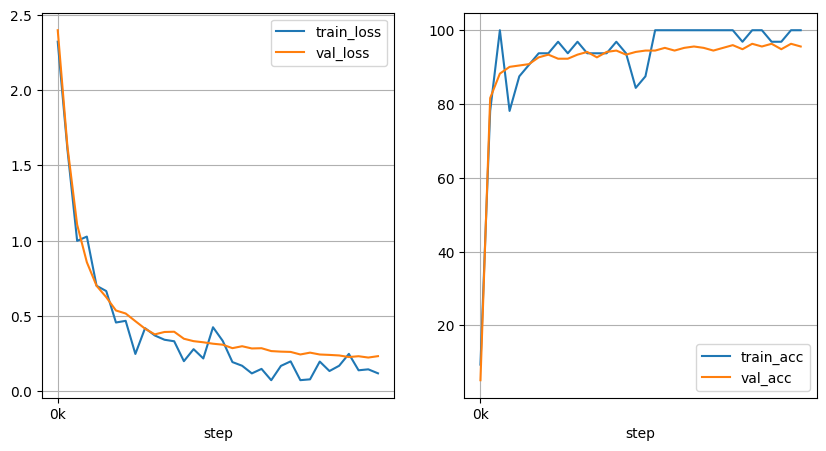

In [17]:
plot_learning_curves(history, sample_step=50)  #横坐标是 steps

In [18]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy


(95.58823529411765, 0.23171196176725276)